In [76]:
from __future__ import division
import warnings

In [77]:
def distance_euclidean(instance1, instance2):
    def detect_value_type(attribute):
        from numbers import Number
        attribute_type = None
        if isinstance(attribute, Number):
            attribute_type = float
            attribute = float(attribute)
        else:
            attribute_type = str
            attribute = str(attribute)
        return attribute_type, attribute
    # check if instances are of same length
    if len(instance1) != len(instance2):
        raise AttributeError("Instances have different number of arguments.")
    differences = [0] * len(instance1)
    for i, (attr1, attr2) in enumerate(zip(instance1, instance2)):
        type1, attr1 = detect_value_type(attr1)
        type2, attr2 = detect_value_type(attr2)
        if type1 != type2:
            raise AttributeError("Instances have different data types.")
        if type1 is float:
            differences[i] = attr1 - attr2
        else:
            if attr1 == attr2:
                differences[i] = 0
            else:
                differences[i] = 1
    rmse = (sum(map(lambda x: x**2, differences)) / len(differences))**0.5
    return rmse

In [79]:
def k_distance(k, instance, instances, distance_function=distance_euclidean):
    distances = {}
    for instance2 in instances:
        distance_value = distance_function(instance, instance2)
        if distance_value in distances:
            distances[distance_value].append(instance2)
        else:
            distances[distance_value] = [instance2]
    distances = sorted(distances.items())
    neighbours = []
    [neighbours.extend(n[1]) for n in distances[:k]]
    k_distance_value = distances[k - 1][0] if len(distances) >= k else distances[-1][0]
    return k_distance_value, neighbours

In [80]:
def reachability_distance(k, instance1, instance2, instances, distance_function=distance_euclidean):
    (k_distance_value, neighbours) = k_distance(k, instance2, instances, distance_function=distance_function)
    return max([k_distance_value, distance_function(instance1, instance2)])

In [81]:
def local_reachability_density(min_pts, instance, instances, **kwargs):
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    reachability_distances_array = [0]*len(neighbours) #n.zeros(len(neighbours))
    for i, neighbour in enumerate(neighbours):
        reachability_distances_array[i] = reachability_distance(min_pts, instance, neighbour, instances, **kwargs)
    if not any(reachability_distances_array):
        warnings.warn("Instance %s (could be normalized) is identical to all the neighbors. Setting local reachability density to inf." % repr(instance))
        return float("inf")
    else:
        return len(neighbours) / sum(reachability_distances_array)

In [82]:
def local_outlier_factor(min_pts, instance, instances, **kwargs):
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    instance_lrd = local_reachability_density(min_pts, instance, instances, **kwargs)
    lrd_ratios_array = [0]* len(neighbours)
    for i, neighbour in enumerate(neighbours):
        instances_without_instance = set(instances)
        instances_without_instance.discard(neighbour)
        neighbour_lrd = local_reachability_density(min_pts, neighbour, instances_without_instance, **kwargs)
        lrd_ratios_array[i] = neighbour_lrd / instance_lrd
    return sum(lrd_ratios_array) / len(neighbours)

In [83]:
def outliers(k, instances, **kwargs):
    instances_value_backup = instances
    outliers = []
    for i, instance in enumerate(instances_value_backup):
        instances = list(instances_value_backup)
        instances.remove(instance)
        l = LOF(instances, **kwargs)
        value = l.local_outlier_factor(k, instance)
        if value > 1:
            outliers.append({"lof": value, "instance": instance, "index": i})
    outliers.sort(key=lambda o: o["lof"], reverse=True)
    return outliers

In [78]:
class LOF:
    
    def __init__(self, instances, normalize=True, distance_function=distance_euclidean):
        self.instances = instances
        self.normalize = normalize
        self.distance_function = distance_function
        if normalize:
            self.normalize_instances()

    def compute_instance_attribute_bounds(self):
        min_values = [float("inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * n.inf
        max_values = [float("-inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * -1 * n.inf
        for instance in self.instances:
            min_values = tuple(map(lambda x,y: min(x,y), min_values,instance)) #n.minimum(min_values, instance)
            max_values = tuple(map(lambda x,y: max(x,y), max_values,instance)) #n.maximum(max_values, instance)

        diff = [dim_max - dim_min for dim_max, dim_min in zip(max_values, min_values)]
        if not all(diff):
            problematic_dimensions = ", ".join(str(i+1) for i, v in enumerate(diff) if v == 0)
            warnings.warn("No data variation in dimensions: %s. You should check your data or disable normalization." % problematic_dimensions)

        self.max_attribute_values = max_values
        self.min_attribute_values = min_values

    def normalize_instances(self):
        if not hasattr(self, "max_attribute_values"):
            self.compute_instance_attribute_bounds()
        new_instances = []
        for instance in self.instances:
            new_instances.append(self.normalize_instance(instance)) # (instance - min_values) / (max_values - min_values)
        self.instances = new_instances

    def normalize_instance(self, instance):
        return tuple(map(lambda value,max,min: (value-min)/(max-min) if max-min > 0 else 0,
                         instance, self.max_attribute_values, self.min_attribute_values))

    def local_outlier_factor(self, min_pts, instance):
        if self.normalize:
            instance = self.normalize_instance(instance)
        return local_outlier_factor(min_pts, instance, self.instances, distance_function=self.distance_function)

In [2]:
import pandas as pd

data = pd.read_csv (r'Desktop/DataMining/lab2/pen-global-unsupervised-ad.csv')

raw_df = pd.DataFrame(data, columns= ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P'])

df = raw_df.apply(lambda x: tuple(x), axis=1).values.tolist()

instances = df

print (df)

[(47, 100, 27, 81, 57, 37, 26, 0, 0, 23, 56, 53, 100, 90, 40, 98), (48, 96, 62, 65, 88, 27, 21, 0, 21, 33, 79, 67, 100, 100, 0, 85), (73, 62, 53, 100, 0, 72, 82, 39, 100, 0, 15, 14, 52, 57, 90, 94), (61, 59, 58, 100, 0, 84, 44, 42, 80, 0, 8, 5, 33, 44, 100, 70), (32, 59, 53, 100, 100, 95, 79, 46, 48, 0, 93, 19, 58, 55, 0, 63), (57, 63, 100, 100, 0, 91, 36, 53, 95, 16, 2, 0, 5, 36, 91, 67), (100, 79, 67, 100, 26, 76, 41, 38, 47, 0, 0, 8, 38, 38, 96, 58), (94, 79, 40, 100, 13, 65, 59, 30, 67, 0, 0, 17, 45, 52, 100, 83), (0, 82, 75, 56, 100, 12, 22, 0, 22, 41, 92, 73, 84, 100, 2, 80), (42, 83, 60, 53, 89, 11, 13, 0, 0, 33, 77, 57, 100, 92, 18, 100), (0, 88, 24, 68, 76, 33, 43, 0, 29, 32, 84, 66, 100, 100, 8, 89), (100, 89, 40, 83, 63, 40, 84, 0, 0, 7, 53, 53, 80, 100, 3, 78), (0, 79, 51, 59, 100, 29, 51, 0, 22, 26, 51, 60, 73, 94, 9, 100), (54, 93, 0, 88, 54, 46, 70, 0, 5, 9, 54, 52, 100, 96, 7, 100), (58, 100, 0, 89, 44, 53, 100, 21, 63, 0, 62, 36, 87, 80, 25, 91), (78, 85, 65, 66, 100, 

In [40]:
lof = outliers(20, instances)

for outlier in lof:
    print (outlier["lof"],outlier["instance"])

3.0865863352904177 (24, 66, 100, 89, 30, 66, 88, 32, 34, 0, 0, 34, 61, 72, 77, 100)
2.558923640327463 (32, 52, 22, 0, 100, 2, 78, 63, 35, 37, 14, 100, 71, 92, 0, 73)
2.260266579371599 (0, 0, 31, 15, 63, 30, 88, 52, 100, 79, 82, 100, 56, 82, 79, 64)
1.6582682627956296 (100, 84, 31, 100, 0, 88, 8, 70, 15, 53, 15, 35, 0, 17, 0, 0)
1.6187676488793836 (0, 33, 66, 60, 100, 100, 48, 78, 84, 37, 52, 0, 30, 32, 85, 68)
1.6007601731884613 (64, 93, 0, 67, 97, 67, 89, 100, 14, 70, 100, 68, 96, 36, 28, 0)
1.595882149214456 (20, 60, 0, 83, 15, 39, 100, 9, 30, 0, 47, 54, 67, 100, 2, 59)
1.590633490399131 (5, 55, 79, 87, 5, 100, 38, 53, 67, 6, 0, 0, 27, 47, 100, 84)
1.5870506164367146 (50, 97, 72, 68, 100, 100, 42, 86, 93, 72, 89, 48, 70, 7, 0, 0)
1.5639926018235246 (0, 100, 54, 98, 91, 85, 71, 52, 62, 17, 74, 0, 100, 32, 42, 37)
1.556877355222356 (85, 52, 85, 98, 0, 79, 65, 39, 100, 0, 9, 13, 62, 56, 100, 100)
1.543318074080529 (0, 79, 25, 50, 98, 25, 71, 0, 10, 16, 50, 47, 100, 76, 83, 100)
1.516629

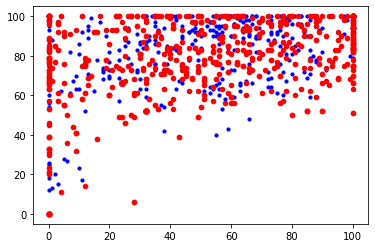

In [53]:
from matplotlib import pyplot as pp

(a,b,c,d,e,f,g,h,i,g,k,l,m,n,o,p) = zip(*instances)
pp.scatter(a, b, 10, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    pp.scatter(instance[0], instance[1], color=color, s=(value-1)*10+20)

pp.show()

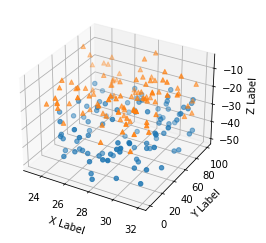

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

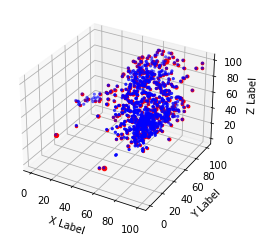

In [59]:
from matplotlib import pyplot as plt

(a,b,c,d,e,f,g,h,i,g,k,l,m,n,o,p) = zip(*instances)

#plt.scatter(a, e, 10, color="#0000FF")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(b, c, d, color="#0000FF", s=5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    ax.scatter(instance[1], instance[2], instance[3], color=color, s=(value-1)*10+5)

plt.show()

In [89]:
import pandas as pd

data = pd.read_csv (r'Downloads/shuttle.csv')

raw_df = pd.DataFrame(data, columns= ['V1','V2','V3','V4','V5','V6','V7','V8','V9'])

df = raw_df.head(40000).apply(lambda x: tuple(x), axis=1).values.tolist()

instances = df

print (instances)

[(50, -1, 89, -7, 50, 0, 39, 40, 2), (55, 2, 82, 0, 54, -6, 26, 28, 2), (41, 0, 84, 3, 38, -4, 43, 45, 2), (37, 0, 100, 0, 36, -8, 63, 64, 2), (46, 0, 83, 0, 46, 0, 37, 36, 0), (44, 0, 79, 0, 42, -17, 35, 37, 2), (44, -1, 78, 0, 44, 0, 34, 34, 0), (55, 0, 81, 0, 54, -10, 25, 26, 2), (37, 0, 100, 0, 34, 6, 64, 67, 4), (43, -3, 86, 2, 44, 14, 43, 42, 0), (46, -5, 84, 0, 46, 0, 38, 37, 0), (45, 0, 81, 0, 44, 0, 36, 37, 0), (48, 0, 86, 0, 50, 30, 38, 37, 0), (45, 5, 90, 0, 44, 0, 44, 46, 2), (37, 0, 77, 0, -20, 27, 41, 98, 58), (37, 0, 90, -6, 18, 0, 53, 72, 20), (37, -8, 77, 0, 20, 0, 40, 57, 16), (50, 5, 95, -3, 50, 0, 45, 46, 2), (43, -2, 76, 0, 44, 15, 32, 32, 0), (42, -1, 85, -5, 42, 0, 44, 44, 0), (37, 0, 76, 0, 26, 20, 39, 50, 12), (37, 0, 76, 8, 30, 0, 40, 45, 6), (45, 0, 106, 0, 46, 9, 61, 60, 0), (37, 0, 81, 0, 38, 17, 44, 43, 0), (49, 4, 83, 0, 46, 0, 34, 37, 2), (50, 0, 88, 1, 50, 0, 38, 39, 0), (42, 2, 77, 0, 42, 0, 36, 36, 0), (49, 0, 78, 0, 50, 11, 29, 29, 0), (37, 0, 77, 0,

In [90]:
lof = LOF(instances)

In [92]:
for instance in [[44,3,77,0,44,14,34,34,0],[37,-2,94,0,34,0,57,61,4],[82,0,87,7,-40,1,5,128,124]]:
    value = lof.local_outlier_factor(10, instance)
    print (value, instance)

1.9479614927533908 [44, 3, 77, 0, 44, 14, 34, 34, 0]
0.9990469042908572 [37, -2, 94, 0, 34, 0, 57, 61, 4]
61.06729264394447 [82, 0, 87, 7, -40, 1, 5, 128, 124]


3.8218037767022977 (52, 0, 37)
3.4994397347310295 (0, 15, 79)
2.6720749923888203 (60, 83, 0)
2.477527921419088 (66, 89, 0)
1.8934387120356164 (46, 64, 75)
1.850540358696421 (38, 29, 57)
1.7601450306566853 (61, 20, 64)
1.6448198667604874 (79, 92, 0)
1.637895357160324 (100, 41, 43)
1.6118514973982627 (45, 36, 38)
1.59892776145318 (100, 93, 6)
1.5836803320590822 (46, 31, 45)
1.5468849714833752 (50, 35, 68)
1.5433969093449256 (68, 70, 12)
1.5037112618254567 (51, 100, 0)
1.4897886234394728 (92, 100, 86)
1.4873470504010944 (64, 29, 65)
1.4670195143836227 (70, 100, 25)
1.4521776997281213 (87, 49, 67)
1.4460315726763113 (70, 36, 66)
1.4458476816406471 (71, 65, 42)
1.445224580915664 (82, 63, 50)
1.4371844803596971 (70, 94, 0)
1.4353025010508027 (79, 50, 16)
1.4194945354914013 (52, 98, 0)
1.4140659810199872 (82, 67, 48)
1.4105756423860372 (83, 87, 33)
1.4052977698506355 (55, 87, 6)
1.3961765197142344 (100, 90, 62)
1.3939023685334586 (84, 41, 51)
1.3881712142350568 (89, 50, 17)
1.3857691753917674

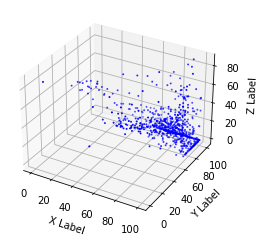

In [71]:
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv (r'Downloads/pen-global-unsupervised-ad.csv')
raw_df = pd.DataFrame(data, columns= ['B','D','J'])
instances = raw_df.apply(lambda x: tuple(x), axis=1).values.tolist()

# (b, d, j) = zip(*instances)
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(b, d, j, color="#0000FF", s=1)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

lof = outliers(10, instances)

for outlier in lof:
    print (outlier["lof"],outlier["instance"])

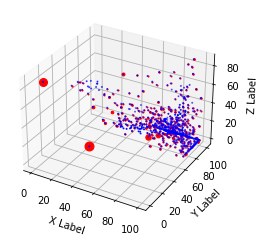

In [73]:
from matplotlib import pyplot as plt

(b,d,j) = zip(*instances)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(b, d, j, color="#0000FF", s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    ax.scatter(instance[0], instance[1], instance[2], color=color, s=(value-1)**2*10+1)

plt.show()